In [94]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score
import random
from scipy.stats import spearmanr

In [2]:
# Pitching dataset without team stats
df = pd.read_csv('PitchingDraftTable_with_teamstats.csv', delimiter=',')

In [3]:
# list and drop columns that are less related to the target
cols_to_drop = ['name', 'playerid', 'mlbamid', 'team', 'Acronym', 'Full Name', 'Full Team Name', 'Drafted By', 'Drafted From', 'team_new', 'division', 'team_id', 'team_teamstats', 'Difference']
df = df.drop(columns=cols_to_drop)
print(df.columns.tolist())

# convert the target to numerical values
df['Drafted?'] = df['Drafted?'].astype(int)

['age', 'nameascii', 'year', 'w', 'l', 'era', 'g', 'gs', 'cg', 'sho', 'sv', 'ip', 'tbf', 'h', 'r', 'er', 'hr', 'bb', 'hbp', 'wp', 'bk', 'so', 'k/9', 'bb/9', 'k/bb', 'hr/9', 'k%', 'bb%', 'k-bb%', 'avg', 'whip', 'babip', 'lob%', 'fip', 'e-f', 'Round', 'Pick', 'Drafted?', 'team_old', 'league', 'W', 'L', 'T', 'G', 'WPCT', 'PE', 'BB (Batting)', 'AB', 'H', 'BA', 'DP', 'DPPG', '2B', '2BPG', 'IP', 'R (Pitching)', 'ER', 'ERA', 'PO', 'A', 'E', 'FPCT', 'HB', 'HBP', 'HA', 'HAPG', 'HR', 'HRPG', 'SF', 'SH', 'OBP', 'SB', 'SBPG', 'CS', 'R (Batting)', 'RPG', 'SHO', 'TB', 'SLG', 'SO', 'BB (Pitching)', 'K/BB', 'K/9', 'TP', '3B', '3BPG', 'WHIP', 'BBPG (Pitching)']


In [4]:
df.head()

,age,nameascii,year,w,l,era,g,gs,cg,sho,...,SLG,SO,BB (Pitching),K/BB,K/9,TP,3B,3BPG,WHIP,BBPG (Pitching)
0,21.0,Gordon Graceffo,2021,7,2,1.536585,11,11,2,1,...,0.331,340.0,125.0,2.72,10.0,NaN,12.0,0.34,1.33,NaN
1,23.0,Patrick Monteverde,2021,7,4,3.752896,16,16,0,0,...,0.491,543.0,225.0,2.41,9.9,NaN,16.0,0.29,1.35,NaN
2,23.0,Alek Jacob,2021,8,1,2.521401,17,11,2,2,...,0.400,488.0,228.0,2.14,9.4,NaN,9.0,0.17,1.40,NaN
3,22.0,Matt Svanson,2021,4,4,2.303317,13,12,0,0,...,0.379,360.0,175.0,2.06,8.9,NaN,12.0,0.28,1.48,NaN
4,21.0,Andrew Hoffmann,2021,3,0,2.872340,11,11,0,0,...,0.429,389.0,160.0,2.43,9.2,NaN,4.0,0.09,1.56,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5642 entries, 0 to 5641
Data columns (total 88 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3138 non-null   float64
 1   nameascii        5642 non-null   object 
 2   year             5642 non-null   int64  
 3   w                5642 non-null   int64  
 4   l                5642 non-null   int64  
 5   era              5642 non-null   float64
 6   g                5642 non-null   int64  
 7   gs               5642 non-null   int64  
 8   cg               5642 non-null   int64  
 9   sho              5642 non-null   int64  
 10  sv               5642 non-null   int64  
 11  ip               5642 non-null   float64
 12  tbf              5642 non-null   int64  
 13  h                5642 non-null   int64  
 14  r                5642 non-null   int64  
 15  er               5642 non-null   int64  
 16  hr               5642 non-null   int64  
 17  bb            

In [6]:
player_features = list(df[['age', 'w', 'l', 'era', 'g', 'gs', 'cg', 'sho', 'sv', 'ip', 'tbf',
                    'h', 'r', 'er', 'hr', 'bb', 'hbp', 'wp', 'bk', 'so', 'k/9', 'bb/9', 'k/bb',
                    'hr/9', 'k%', 'bb%', 'k-bb%', 'avg', 'whip', 'babip', 'lob%', 'fip', 'e-f']].columns)

team_features = list(df[['W', 'L', 'T', 'G', 'WPCT', 'PE', 'BB (Batting)', 'AB', 'H', 'BA', 'DP', 
                    'DPPG', '2B', '2BPG', 'IP', 'R (Pitching)', 'ER', 'ERA', 'PO', 'A', 'E', 
                    'FPCT', 'HB', 'HBP', 'HA', 'HAPG', 'HR', 'HRPG', 'SF', 'SH', 'OBP', 
                    'SB', 'SBPG', 'CS', 'R (Batting)', 'RPG', 'SHO', 'TB', 'SLG', 'SO', 'BB (Pitching)', 
                    'K/BB', 'K/9', 'TP', '3B', '3BPG', 'WHIP', 'BBPG (Pitching)']].columns)

redundant_features = ['k%', 'bb%', 'K/BB', 'k/bb']
lasso_selected_features = [
    'age', 'fip', 'K/9', 'WHIP', 'so', 'g', 'L', 'hr/9', 'wp', 'l', 'ER',
    'HRPG', 'SF', 'babip', 'SHO', 'A', 'bk', 'BB (Pitching)', 'PE', '3B',
    'ip', 'FPCT', 'CS', 'w', 'HB', 'DPPG', 'SH', 'T', 'SO', 'BBPG (Pitching)',
    'SBPG', 'cg', 'RPG', 'k-bb%', 'HBP', '2BPG', 'sho', 'e-f', 'lob%', 'sv', 'E'
]
lasso_selected_features = [f for f in lasso_selected_features if f not in redundant_features]
features = player_features + team_features
#features = lasso_selected_features

df = pd.get_dummies(df, columns=['league'], drop_first=True)
df = pd.get_dummies(df, columns=['team_old'], drop_first=True)

X = df[features]
y = df['Drafted?'].astype(int)

In [7]:
# Separate the two classes
drafted_indices = df[df['Drafted?'] == 1].index
not_drafted_indices = df[df['Drafted?'] == 0].index

print(f"Original class distribution:")
print(f"  Class 0 (Not Drafted): {len(not_drafted_indices)}")
print(f"  Class 1 (Drafted): {len(drafted_indices)}")

# Randomly sample from class 0 to match class 1 size
np.random.seed(42)  # for reproducibility
undersampled_not_drafted = np.random.choice(not_drafted_indices, size=len(drafted_indices), replace=False)

# Combine the balanced indices
balanced_indices = np.concatenate([drafted_indices, undersampled_not_drafted])
np.random.shuffle(balanced_indices)

# Create balanced dataset
X_balanced = X.loc[balanced_indices]
y_balanced = y.loc[balanced_indices]

print(f"\nBalanced class distribution:")
print(f"  Class 0 (Not Drafted): {sum(y_balanced == 0)}")
print(f"  Class 1 (Drafted): {sum(y_balanced == 1)}")
print(f"  Total samples: {len(y_balanced)}")
print(f"  Class 1 percentage: {sum(y_balanced == 1) / len(y_balanced) * 100:.1f}%")

Original class distribution:
  Class 0 (Not Drafted): 4964
  Class 1 (Drafted): 678

Balanced class distribution:
  Class 0 (Not Drafted): 678
  Class 1 (Drafted): 678
  Total samples: 1356
  Class 1 percentage: 50.0%


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

In [17]:
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

print(f"\nTraining set distribution:")
print(f"  Class 0: {neg_count}")
print(f"  Class 1: {pos_count}")
print(f"  Scale_pos_weight: {scale_pos_weight:.2f}")


Training set distribution:
  Class 0: 542
  Class 1: 542
  Scale_pos_weight: 1.00


In [19]:
draft_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

draft_model.fit(X_train, y_train)

y_pred = draft_model.predict(X_test)
y_proba = draft_model.predict_proba(X_test)[:,1]

print("\nDrafted? Classifier Results (Balanced Dataset):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))


🎯 Drafted? Classifier Results (Balanced Dataset):
Accuracy: 0.868

              precision    recall  f1-score   support

           0      0.903     0.824     0.862       136
           1      0.838     0.912     0.873       136

    accuracy                          0.868       272
   macro avg      0.871     0.868     0.867       272
weighted avg      0.871     0.868     0.867       272



In [20]:
importance = draft_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Features by Importance:")
print(importance_df.head(20))


Top 20 Features by Importance:
   Feature  Importance
0      age   11.928389
19      so    7.509110
24      k%    3.522614
74     K/9    3.404117
71      SO    3.273584
53    FPCT    2.785270
37      PE    2.578971
77    WHIP    2.185674
26   k-bb%    1.972978
31     fip    1.972104
73    K/BB    1.526326
59    HRPG    1.504588
70     SLG    1.470625
62     OBP    1.463632
49     ERA    1.430228
18      bk    1.427618
46      IP    1.427006
4        g    1.329674
35       G    1.328841
21    bb/9    1.324552


In [104]:
target_drafted = 'Drafted?'
target_pick = 'Pick'

drafted_df = df[df[target_drafted] == 1]
X_drafted = drafted_df[features]
y_pick = drafted_df[target_pick]

X_train_pick, X_test_pick, y_train_pick, y_test_pick = train_test_split(
    X_drafted, y_pick, test_size=0.2, random_state=42
)

pick_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)

pick_model.fit(X_train_pick, y_train_pick)

pick_preds = pick_model.predict(X_test_pick)

print("\nPick Prediction:")
print(f"MAE: {mean_absolute_error(y_test_pick, pick_preds):.3f}")

corr, _ = spearmanr(y_test_pick, pick_preds)
print(f"Spearman correlation: {corr:.3f}")


Pick Prediction:
MAE: 106.221
Spearman correlation: 0.612


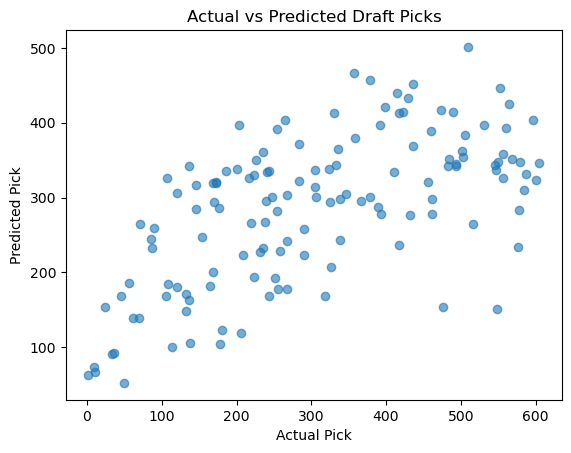

Spearman correlation: 0.612


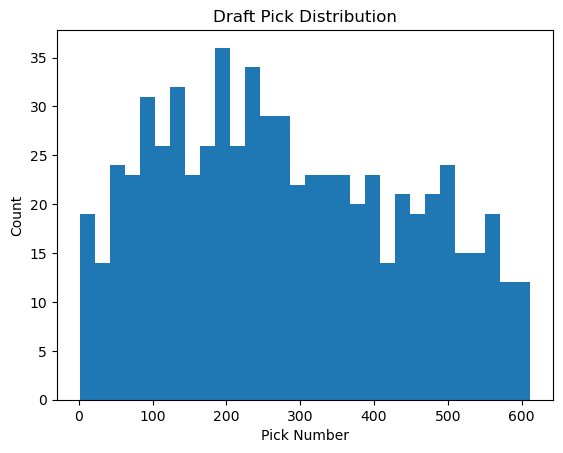

In [92]:
plt.scatter(y_test_pick, pick_preds, alpha=0.6)
plt.xlabel("Actual Pick")
plt.ylabel("Predicted Pick")
plt.title("Actual vs Predicted Draft Picks")
plt.show()

import matplotlib.pyplot as plt
plt.hist(y_pick, bins=30)
plt.xlabel("Pick Number")
plt.ylabel("Count")
plt.title("Draft Pick Distribution")
plt.show()

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

target_drafted = 'Drafted?'
X = df[features]
y = df[target_drafted]
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, solver='liblinear')
)
log_reg.fit(X_clean, y_clean)


,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [142]:
coefficients = log_reg.named_steps['logisticregression'].coef_[0]
coef_df = pd.DataFrame({
    'Feature': features,
    'LogReg_Weight': coefficients
}).sort_values(by='LogReg_Weight', ascending=False)

importance = draft_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'XGB_Importance': list(importance.values())
})

# Merge the two
comparison_df = coef_df.merge(importance_df, on='Feature', how='inner')

# Sort by XGBoost importance or weight magnitude
comparison_df = comparison_df.sort_values(by='XGB_Importance', ascending=False)
comparison_df = comparison_df.reset_index(drop=True)
pd.set_option('display.max_rows', None)
print(comparison_df)

#print(comparison_df.head(20))


            Feature  LogReg_Weight  XGB_Importance
0               age      -0.048351       11.928389
1                so       0.510728        7.509110
2                k%       0.177178        3.522614
3               K/9      -0.079961        3.404117
4                SO      -0.035836        3.273584
5              FPCT      -0.068953        2.785270
6                PE       0.088503        2.578971
7              WHIP      -0.086597        2.185674
8             k-bb%       0.126827        1.972978
9               fip      -0.062818        1.972104
10             K/BB      -0.082651        1.526326
11             HRPG       0.131985        1.504588
12              SLG       0.082544        1.470625
13              OBP       0.088782        1.463632
14              ERA      -0.091901        1.430228
15               bk      -0.602940        1.427618
16               IP       0.027908        1.427006
17                g      -0.655719        1.329674
18                G       0.101

In [152]:
missing_summary = X.isnull().mean().sort_values(ascending=False)
print(missing_summary[missing_summary > 0].head(1000))

TP                 0.981567
age                0.443814
BBPG (Pitching)    0.217476
SHO                0.211804
3BPG               0.023928
3B                 0.023928
BA                 0.023396
HA                 0.023396
HBP                0.023396
HB                 0.023396
FPCT               0.023396
E                  0.023396
A                  0.023396
PO                 0.023396
ERA                0.023396
HR                 0.023396
ER                 0.023396
R (Pitching)       0.023396
IP                 0.023396
2BPG               0.023396
2B                 0.023396
DPPG               0.023396
HAPG               0.023396
SF                 0.023396
HRPG               0.023396
TB                 0.023396
WHIP               0.023396
K/9                0.023396
K/BB               0.023396
BB (Pitching)      0.023396
SO                 0.023396
SLG                0.023396
RPG                0.023396
H                  0.023396
R (Batting)        0.023396
CS                 0